<a href="https://colab.research.google.com/github/HarlinLee/PSC/blob/main/experiments/neuron/stimulus_space_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load packages and data

In [1]:
!pip install ripser
!pip install pymanopt
!pip install dreimac
!pip install geomstats

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/PSC"
output_folder = "/content/drive/MyDrive/PSC/experiments/neuron"

import sys
sys.path.insert(0, os.path.join(DRIVE_PATH, 'PSC'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load path

f = h5py.File(os.path.join(output_folder,'100_neurons_13k_steps_nonuniform_half_random_walk.h5'), 'r')
path = np.array(f.get('path'))
path = path*2*np.pi

In [ ]:
# # Load response matrix
# from sklearn.preprocessing import normalize

# f = h5py.File(os.path.join(output_folder,'response_matrix.h5'), 'r')
# response_matrix = np.array(f.get('raster')).T
# print(response_matrix.shape)

# # Center and normalize data
# response_matrix -= np.mean(response_matrix)
# response_matrix = normalize(response_matrix, norm = 'l2', axis = 0).T

In [5]:
# Load response matrix

f = h5py.File(os.path.join(output_folder,'centered_normalized_response_matrix_100_neurons_13k_steps_nonuniform_half_random_walk.h5'), 'r')
response_matrix = np.array(f.get('raster')).T
print(response_matrix.shape)

(13000, 100)


In [6]:
num_points = response_matrix.shape[0] # 13000

N = response_matrix.shape[1] # 100
n = 2
k = 1

results = {}

In [7]:
def get_angle(X):
  theta = np.arctan2(X[:,1], X[:,0]) # [-pi, pi]
  theta[theta <0] += 2*np.pi # [0, 2*pi]

  return theta

# PSC Pipeline

In [8]:
from utils import projection_cost, nuc_cost
from projections import PCA, manopt_alpha, yhat_alpha_all

from pymanopt.manifolds.stiefel import Stiefel


INFO:root:Using numpy backend


In [9]:
ys = response_matrix[:, :, np.newaxis]
ys = ys - np.mean(ys, axis=0)

print(ys.shape)

alpha_PCA = PCA(ys, n)
alpha_GD = manopt_alpha(ys, alpha_PCA)

St_Nn = Stiefel(N, n)
alpha_random = St_Nn.random_point() # for comparison

for alpha, name in zip([alpha_PCA, alpha_GD, alpha_random],
                 ['PCA', 'GD', 'random']):
    print(name)
    print('    projection cost:', projection_cost(alpha, ys))
    print('    nuclear norm cost:', nuc_cost(alpha, ys))
    print()


(13000, 100, 1)
Optimizing...
Terminated - min grad norm reached after 53 iterations, 289.36 seconds.

PCA
    projection cost: 1.2614191670098505
    nuclear norm cost: -0.3657482147150762

GD
    projection cost: 1.1738332255607766
    nuclear norm cost: -0.409541185439613

random
    projection cost: 1.7806582989218436
    nuclear norm cost: -0.10612864875907975



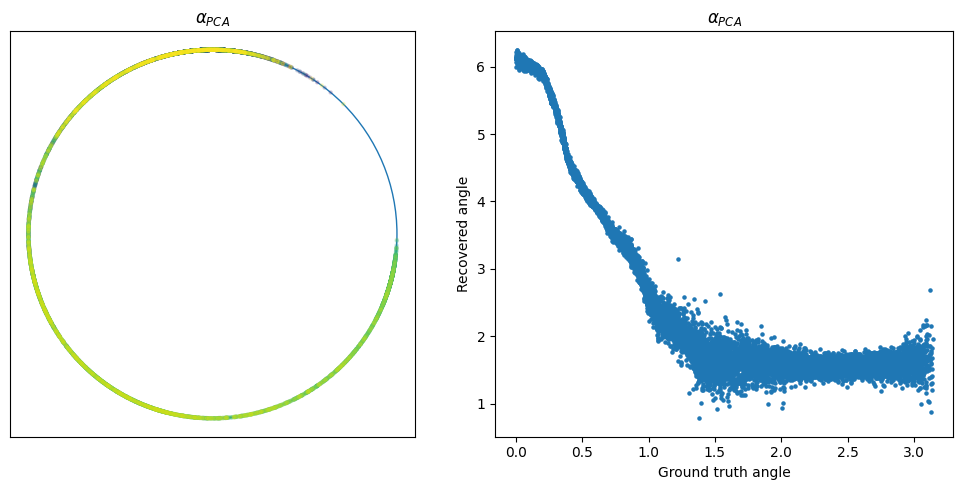

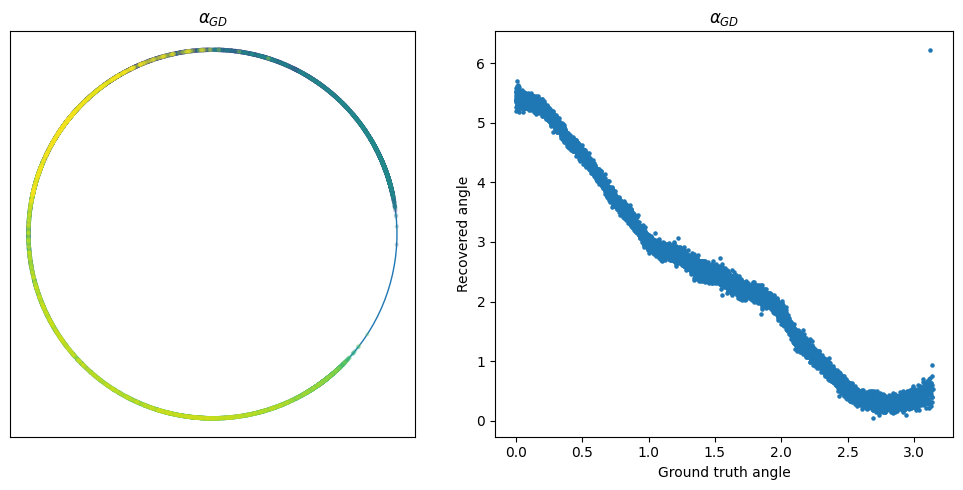

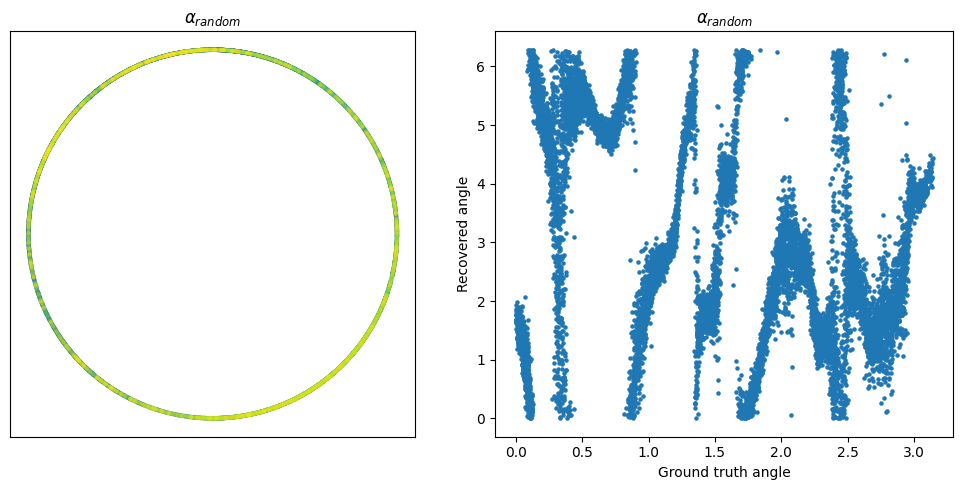

In [10]:
def recover_parameters(alpha, name):
  y_hats = yhat_alpha_all(alpha, ys)
  y_hats = np.array(y_hats).squeeze()

  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  # Plot recovered data

  t = np.linspace(0,np.pi*2,100)
  circ = plt.Circle((0, 0), radius=1, edgecolor='tab:blue', facecolor='None')
  ax[0].add_patch(circ)
  ax[0].scatter(y_hats[:, 0], y_hats[:, 1], c=range(len(y_hats)), s=5, alpha=0.2)
  ax[0].set_box_aspect((1))

  ax[0].set_xticks([])
  ax[0].set_yticks([])

  ax[0].tick_params(axis='both', which='major', labelsize=14)
  ax[0].tick_params(axis='both', which='minor', labelsize=14)
  ax[0].set_title(r'$\alpha_{'+name+r'}$')

  # Scatter plot of recovered coordinates against known coordinates
  theta = get_angle(y_hats)

  ax[1].scatter(path, theta, s=5)
  ax[1].set_xlabel("Ground truth angle")
  ax[1].set_ylabel("Recovered angle")
  ax[1].set_title(r'$\alpha_{'+name+r'}$')
  plt.tight_layout()
  plt.show()

  return y_hats, theta


# Recover parameterization
for alpha, name in zip([alpha_PCA, alpha_GD, alpha_random],
                 [r'PCA', r'GD', r'random']):

  y_hats, theta = recover_parameters(alpha, name)
  results[name] = theta

In [11]:
import pickle

with open(os.path.join(output_folder, 'PSC.pkl'), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Persistent cohomology pipeline

In [12]:
# Import circular coordinates package
from ripser import ripser
from dreimac import CircularCoords

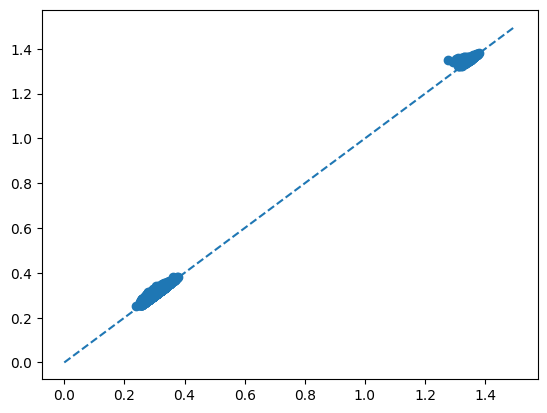

In [13]:
# Perform persistent cohomology calculation and plot persistence diagram

res = ripser(response_matrix, coeff=17, do_cocycles=True)
diagrams = res['dgms']
cocycles = res['cocycles']
D = res['dperm2all']
dgm1 = diagrams[1]
plt.scatter(dgm1[:,0], dgm1[:,1])
plt.plot([0,1.5],[0,1.5], linestyle = '--')

In [ ]:
# Run circular coordinates

# Optional command to control number of threads if there are performance issues
# Sometimes, fewer threads, e.g. 1, is significantly better
# os.environ['OPENBLAS_NUM_THREADS'] = '1'

cc = CircularCoords(response_matrix, n_landmarks = 10000)

# Select highest-persistence class

max_diff = -1  # Initialize with a negative value to ensure any difference is greater
max_diff_index = -1

for i, row in enumerate(cc.dgms_[1]):
    diff = abs(row[0] - row[1])
    if diff > max_diff:
        max_diff = diff
        max_diff_index = i

print(max_diff_index)

# Run circular coordinates algorithm to obtain map to S^1 with highest-persistence class
circ_coords = cc.get_coordinates(perc=.4, cocycle_idx=max_diff_index, standard_range=False)

results['Persistent cohomology'] = circ_coords - np.pi


0


In [ ]:
# Scatter plot of recovered coordinates against known coordinates

plt.scatter(path, results['Persistent cohomology'])
plt.xlabel("Ground truth angle")
plt.ylabel("Recoverd angle")
plt.show()


In [ ]:
# Create an HDF5 file and write the data
with h5py.File(os.path.join(output_folder,'circ_coords.h5'), 'w') as file:
    # Create a dataset and write the data to it
    file.create_dataset('coords', data=circ_coords)

# MDS Pipeline

In [ ]:
from sklearn.manifold import MDS # for MDS dimensionality reduction


In [ ]:
# Run MDS on data set.
# For large data sets, this can take over an hour. One may instead use "MDS_script.py" and then load the results

model2d=MDS(n_components=n,
          metric=True,
          n_init=4,
          max_iter=150,
          verbose=0,
          eps=0.001,
          n_jobs=None,
          random_state=42,
          dissimilarity='euclidean')

### Step 2 - Fit the data and transform it, so we have 2 dimensions instead of 3
X_trans = model2d.fit_transform(response_matrix)
theta = get_angle(X_trans)
results['MDS'] = theta

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [ ]:
# Plot MDS

plt.cla()
plt.scatter(X_trans[:,0], X_trans[:,1])
plt.show()

In [ ]:
# Scatter plot of recovered coordinates against known coordinates

plt.scatter(path, theta)
plt.xlabel("Ground truth angle")
plt.ylabel("Recovered angle")
plt.show()


In [ ]:
# Create an HDF5 file and write the data
with h5py.File(os.path.join(output_folder,'mds.h5'), 'w') as file:
    # Create a dataset and write the data to it
    file.create_dataset('mds', data=X_trans)

# Plot everything together

In [26]:
with open(os.path.join(output_folder, 'PSC.pkl'), 'rb') as handle:
    results = pickle.load(handle)

f = h5py.File(os.path.join(output_folder,'circ_coords.h5'), 'r')
results['Persistent cohomology'] = np.array(f.get('coords'))

f = h5py.File(os.path.join(output_folder,'mds.h5'), 'r')
results['MDS'] = get_angle(np.array(f.get('mds')))

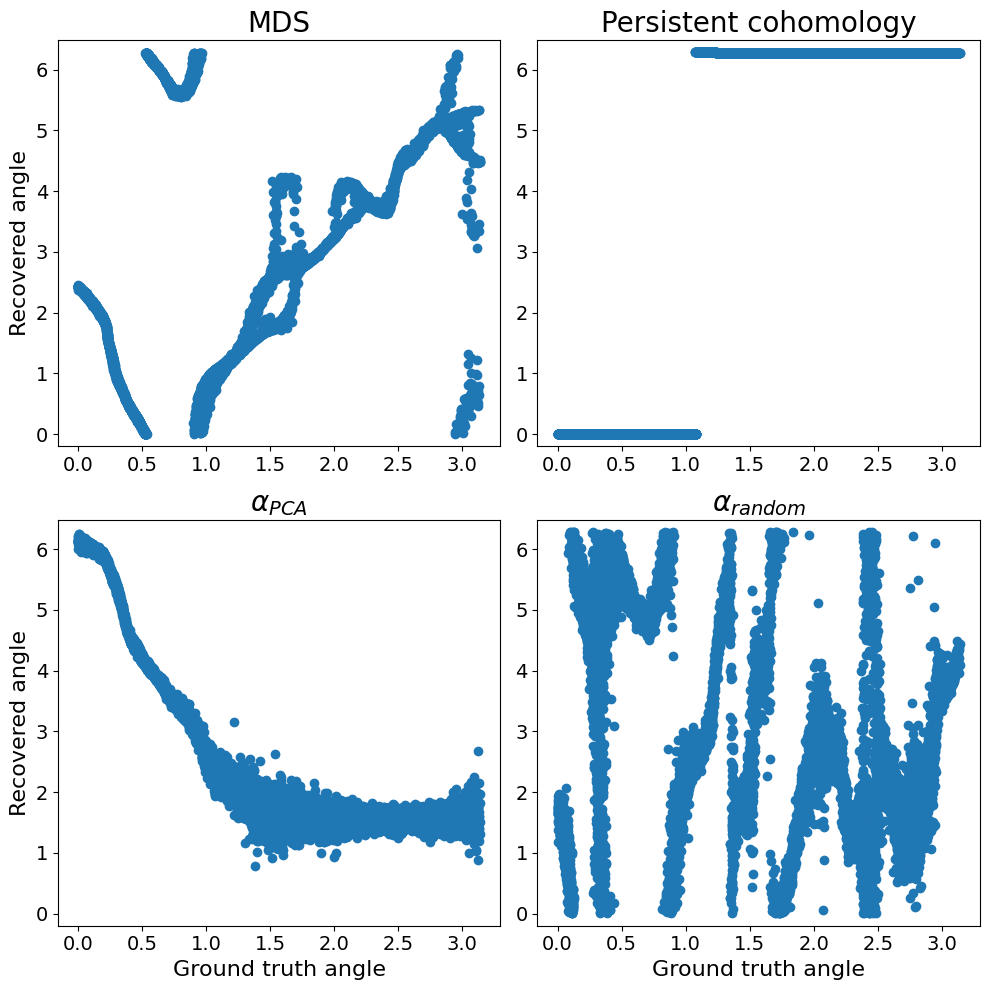

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# first row
for idx, name in zip([0, 1], ['MDS', 'Persistent cohomology']):

  ax[0, idx].scatter(path, results[name])
  ax[0, idx].set_title(name, fontsize=20)
  ax[0, idx].set_ylim([0-0.2, 2*np.pi+0.2])
  ax[0, idx].tick_params(labelsize=14)

# second row
for idx, name in zip([0, 1], [r'PCA', r'random']):

  ax[1, idx].scatter(path, results[name])
  ax[1, idx].set_title(r'$\alpha_{'+name+r'}$', fontsize=20)
  ax[1, idx].set_ylim([0-0.2, 2*np.pi+0.2])
  ax[1, idx].tick_params(labelsize=14)

ax[1, 0].set_xlabel("Ground truth angle", fontsize=16)
ax[1, 1].set_xlabel("Ground truth angle", fontsize=16)
ax[0, 0].set_ylabel("Recovered angle", fontsize=16)
ax[1, 0].set_ylabel("Recovered angle", fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'comparisons-others.pdf'), dpi=300)
plt.show()

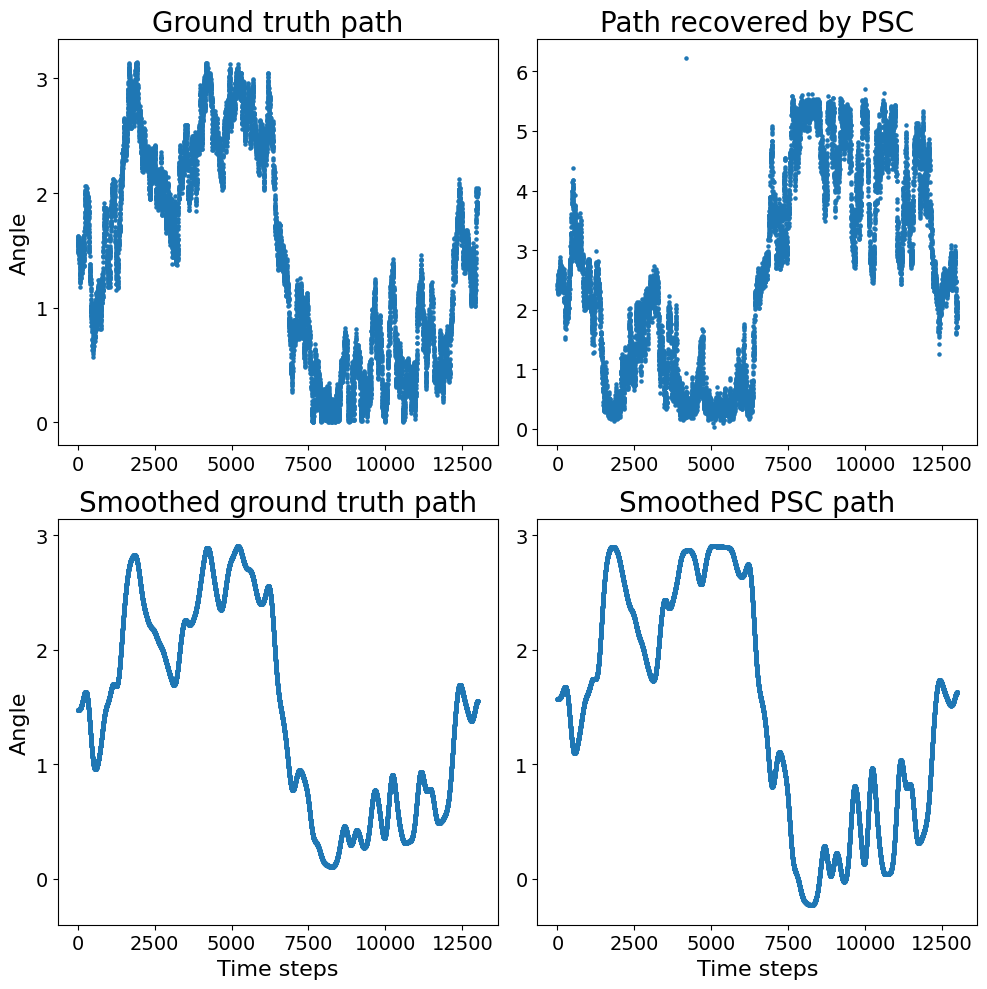

In [69]:
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(range(len(path)), path, s=5)
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].set_title('Ground truth path', fontsize=20)
ax[0, 0].set_ylabel('Angle', fontsize=16)
ax[0, 0].set_ylim([0-0.2, np.pi+0.2])
ax[0, 0].set_yticks([0, 1, 2, 3])

ax[0, 1].scatter(range(len(results['GD'])), results['GD'], s=5)
ax[0, 1].tick_params(labelsize=14)
ax[0, 1].set_title('Path recovered by PSC', fontsize=20)
ax[0, 1].set_yticks([0, 1, 2, 3, 4, 5, 6])

PSC = -results['GD'] + 2*np.pi
PSC = gaussian_filter1d(PSC, sigma=100)

scale = (PSC.max()-PSC.min())/(path.max()-path.min())
PSC /= scale
PSC -= (PSC[0] - path[0])

ax[1, 1].scatter(range(len(PSC)), PSC, s=5)
ax[1, 1].tick_params(labelsize=14)
ax[1, 1].set_title('Smoothed PSC path', fontsize=20)
ax[1, 1].set_xlabel('Time steps', fontsize=16)
ax[1, 1].set_ylim([0-0.4, np.pi])
ax[1, 1].set_yticks([0, 1, 2, 3])

smooth_path = gaussian_filter1d(path, sigma=100)
ax[1, 0].scatter(range(len(smooth_path)), smooth_path, s=5)
ax[1, 0].tick_params(labelsize=14)
ax[1, 0].set_title('Smoothed ground truth path', fontsize=20)
ax[1, 0].set_xlabel('Time steps', fontsize=16)
ax[1, 0].set_ylabel('Angle', fontsize=16)
ax[1, 0].set_ylim([0-0.4, np.pi])
ax[1, 0].set_yticks([0, 1, 2, 3])

plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'comparisons-path.pdf'), dpi=300)
plt.show()

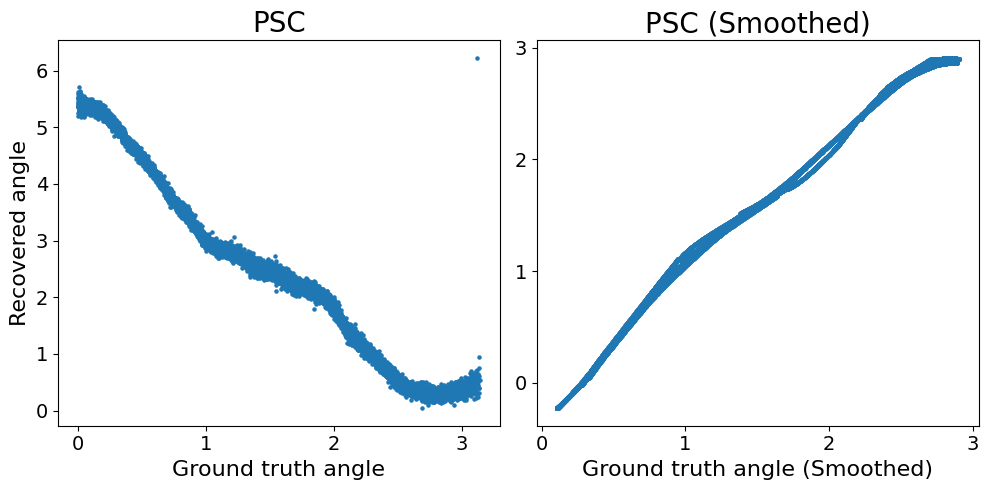

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(path, results['GD'], s=5)

ax[0].set_title('PSC', fontsize=20)
ax[0].set_xlabel("Ground truth angle", fontsize=16)
ax[0].set_ylabel("Recovered angle", fontsize=16)
ax[0].tick_params(labelsize=14)
ax[0].set_xticks([0, 1, 2, 3])
ax[0].set_yticks([0, 1, 2, 3, 4, 5, 6])

ax[1].scatter(smooth_path, PSC, s=5)

ax[1].set_title('PSC (Smoothed)', fontsize=20)
ax[1].set_xlabel("Ground truth angle (Smoothed)", fontsize=16)
ax[1].tick_params(labelsize=14)
ax[1].set_xticks([0, 1, 2, 3])
ax[1].set_yticks([0, 1, 2, 3])

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "psc_path.pdf"), dpi=300)
plt.show()

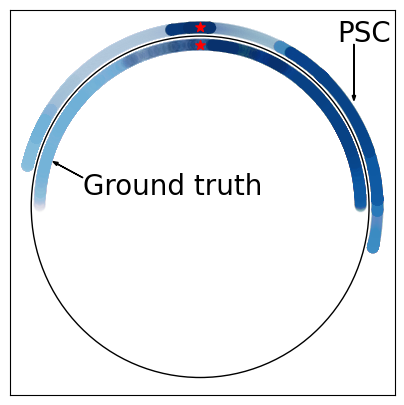

In [132]:
from matplotlib.patches import Arc

fig, ax = plt.subplots(1, figsize=(5,5))

circ = plt.Circle((0, 0), radius=1, edgecolor='k', facecolor='None')
ax.add_patch(circ)

# arc = Arc((0, 0), 2, 2, color='b', theta1=-30, theta2=200)
# ax.add_patch(arc)

r = 0.05
ax.scatter((1-r)*np.cos(path), (1-r)*np.sin(path), c=range(len(PSC)), s=60, alpha=0.01, cmap='Blues')
ax.text((1-10*r)*np.cos(3)-0.2, (1-10*r)*np.sin(3), "Ground truth", fontsize=20)
ax.arrow((1-10*r)*np.cos(3)-0.2, (1-10*r)*np.sin(3)+0.1, -0.15, 0.08, head_width=0.02, facecolor='k', edgecolor='k')

ax.scatter((1+r)*np.cos(PSC), (1+r)*np.sin(PSC), c=range(len(PSC)), s=60, alpha=0.01, cmap='Blues')
ax.text((1+10*r)*np.cos(1), (1+10*r)*np.sin(1)-0.3, "PSC", fontsize=20)
ax.arrow((1+10*r)*np.cos(1)+0.1, (1+5*r)*np.sin(1)-0.1, 0, -0.3, head_width=0.02, facecolor='k', edgecolor='k')

ax.scatter((1-r)*np.cos(path[0]), (1-r)*np.sin(path[0]), c='r', marker='*', s=50)
ax.scatter((1+r)*np.cos(PSC[0]), (1+r)*np.sin(PSC[0]), c='r', marker='*', s=50)

ax.set_box_aspect((1))

ax.set_xticks([])
ax.set_yticks([])
ax.set_box_aspect((1))
plt.savefig(os.path.join(output_folder, "psc_angle.pdf"), dpi=300)
plt.show()